## QAOA for Max k-cut
Example usage of the MaxKCut problem classes. The circuits can be plotted by running

```python
qaoa.createParameterizedCircuit(1)
qaoa.parameterized_circuit.draw(output="mpl")
```

There are two main encodings of the problem: **onehot** and **binary** encoding.

In [1]:
# Import necessary modules from the QAOA package
from qaoa import QAOA, problems, mixers, initialstates

In [2]:
# Import other necessary modules
import numpy as np
import networkx as nx
import sys
import matplotlib.pyplot as pl

sys.path.append("../")
from plotroutines import *

### Onehot encoding
Onehot encoding uses $k$ qubits to represent each state, where $m^{\text{th}}$ qubit is $1$ and the others $0$ representing color $m < k$. A QAOA instance using onehot encoding uses the `MaxKCutOneHot` problem, the `Dicke` Initialstate and the `XY` Mixer.

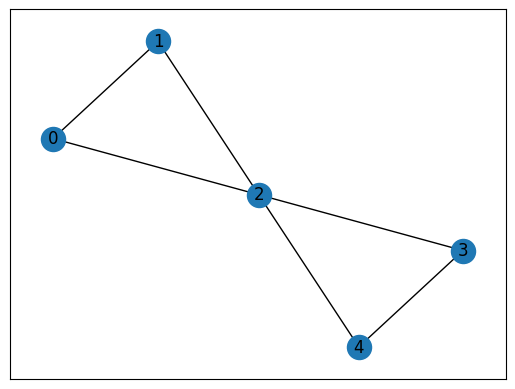

In [3]:
G = nx.Graph()
G.add_nodes_from(np.arange(0, 5, 1)) # Create a graph with 5 nodes
G.add_weighted_edges_from(
    [(0, 1, 1.0), (0, 2, 1.0), (1, 2, 1.0), (3, 2, 1.0), (3, 4, 1.0), (4, 2, 1.0)]
)

pos = nx.spring_layout(G) # Position nodes using a spring layout
nx.draw_networkx(G, pos=pos)

In [4]:
# Initialize QAOA instance
k= 3 # Number of cuts/colors
qaoa = QAOA(
    problem=problems.MaxKCutOneHot(G, k_cuts=k),
    initialstate=initialstates.Dicke(k),
    mixer=mixers.XY()
)

### Binary encoding

Binary encoding uses (considerably) less qubits than onehot encoding, and is therefore more efficient. We need to consider two cases for this encoding: $k$ a power of two and $k$ *not* a power of two.

**$k$ is a power of two**

In this case we use the `MaxKCutBinaryPowerOfTwo` problem Hamiltonian. We typically use the `Plus` initial state (equal superposition $|\psi\rangle_0 = |+\rangle$) and the `X` mixer.

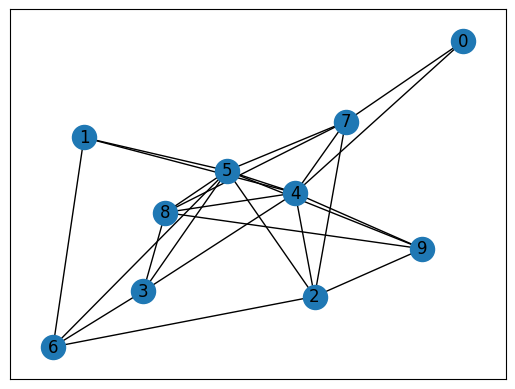

In [6]:
G = nx.read_gml("data/w_ba_n10_k4_0.gml") # Load graph data for 10-node graph
nx.draw_networkx(G)
plt.show()

In [7]:
# Initialize QAOA instance
qaoa = QAOA(
    problem=problems.MaxKCutBinaryPowerOfTwo(G, k_cuts=4),
    mixer=mixers.X(),
    initialstate=initialstates.Plus(),
)

**$k$ is not a power of two**

When $k$ isn't a power of two, there are more computational basis states than there are colors. For this case, we have two options for the problem:

`MaxKCutBinaryFullH`

For when $k$ isn't a power of two and one wishes to use `Plus` initial state and some unconstrained mixer like the `X` mixer, one uses the *full* problem Hamiltonian. In this case different bitstrings must be grouped together to represent the same color, which must be encoded into the problem Hamiltonian $H_P$. The type of `color_encoding` is passed into the problem initialization and is `"LessThanK"` (one color gets assigned all the *extra* states) and `"max_balanced"` (the colors are grouped in the most balanced way). It is not evident which of these is favourable. 

So far, this class is only implemented for `k = 3`, `k = 5`, `k = 6` and `k = 7`.

For `k = 3` only the `"LessThanK"` encoding is available.

In [9]:
qaoa = QAOA(
    problem=problems.MaxKCutBinaryFullH(G, k_cuts=3, color_encoding="LessThanK"),
    mixer=mixers.X(),
    initialstate=initialstates.Plus())

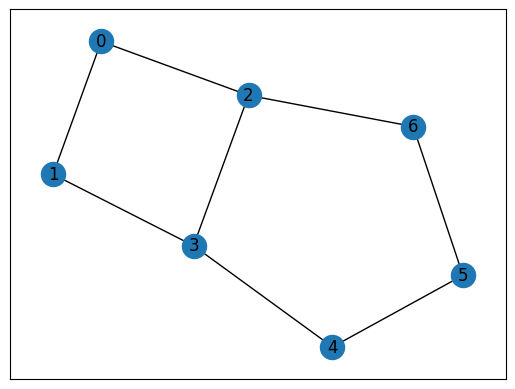

In [11]:
G.add_nodes_from(np.arange(0, 7, 1))

# Homemade graph for testing purposes
G = nx.Graph() # Create an empty graph
G.add_weighted_edges_from([
    (0, 1, 1.0),
    (0, 2, 1.0),
    (1, 3, 1.0),
    (2, 3, 1.0),
    (3, 4, 1.0),
    (4, 5, 1.0),
    (5, 6, 1.0),
    (6, 2, 1.0)
])

pos = nx.spring_layout(G) # Position nodes using a spring layout
nx.draw_networkx(G, pos=pos) # Draw the graph with the specified positions

In [12]:
qaoa = QAOA(
    problem=problems.MaxKCutBinaryFullH(G, k_cuts=5, color_encoding="max_balanced"),
    mixer=mixers.X(),
    initialstate=initialstates.Plus())

`MaxKCutBinaryPowerOfTwo`

We may round up $k$ to the nearest power of two and use the power-of-two problem Hamiltonian. In this case the initial state should be a superposition of *feasible states only*, a *subset* of $k$ computational basis states, generated by the `LessThanK` initial state class. <span style="color:red">NB: The LessThanK initial state class and the "LessThanK" argument in the MaxKCutBinaryPowerOfTwo class initialization refer to different concepts!</span> The initial state will then be an equal superposition of a *subset* of $k$ computational basis vectors, which the phase-separating layer never will evolve to an infeasible state. One does, however, need to use a constrained mixer for the mixing layer, `MaxKCutGrover` or `MaxKCutLX`.

In [14]:
rounded_k = 4
k = 3
qaoa = QAOA(
    problem=problems.MaxKCutBinaryPowerOfTwo(G, k_cuts=rounded_k),
    mixer=mixers.MaxKCutLX(k_cuts=k, color_encoding="LessThanK"),
    initialstate=initialstates.LessThanK(k))

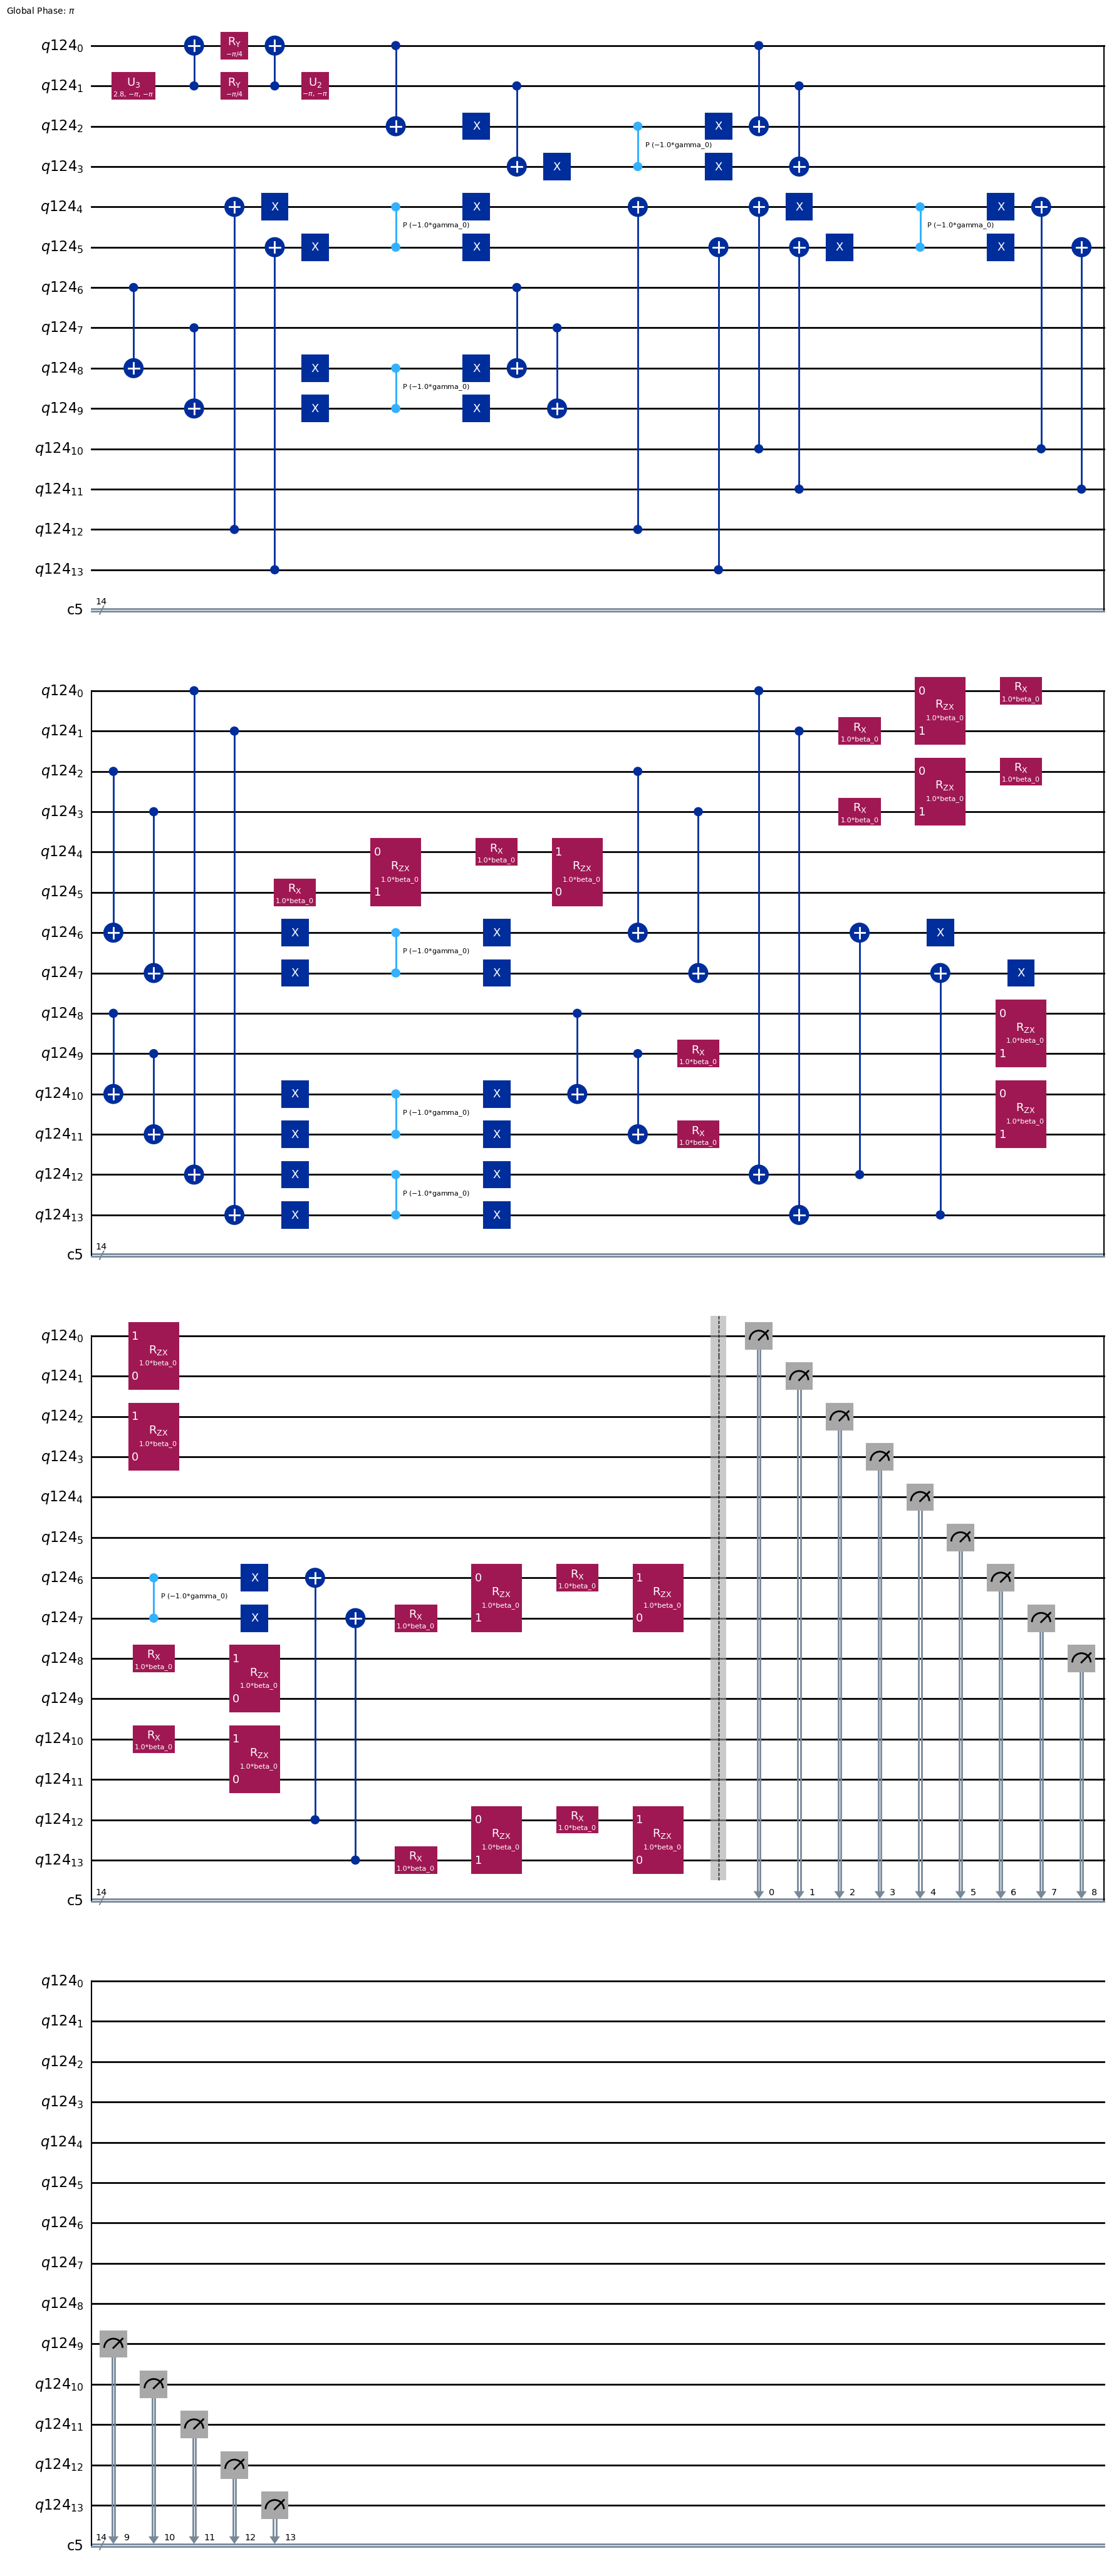

In [15]:
qaoa.createParameterizedCircuit(1)
qaoa.parameterized_circuit.draw(output="mpl")